In [1]:
library(rdmc)
library(tidyverse)
library(ape)

Loading required package: MASS

Loading required package: dplyr


Attaching package: ‘dplyr’


The following object is masked from ‘package:MASS’:

    select


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: tidyr

Loading required package: purrr

Loading required package: magrittr


Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract


Loading required package: rlang


Attaching package: ‘rlang’


The following object is masked from ‘package:magrittr’:

    set_names


The following objects are masked from ‘package:purrr’:

    %@%, as_function, flatten, flatten_chr, flatten_dbl, flatten_int,
    flatten_lgl, flatten_raw, invoke, list_along, modify, prepend,
    splice


── Attaching packages ───────────────────────────────

In [2]:
FREQ_POPS = c(
    "chrom",
    "start",
    "end",
    "v5--LR--Amatlan_de_Canas",
    "v5--LR--Crucero_Lagunitas",
    "v5--LR--Los_Guajes",
    "v5--LR--random1_Palmar_Chico",
    "v5--LR--San_Lorenzo",
    "v5--Teo--Amatlan_de_Canas",
    "v5--Teo--Crucero_Lagunitas",
    "v5--Teo--El_Rodeo",
    "v5--Teo--Los_Guajes",
    "v5--Teo--random1_Palmar_Chico",
    "v5--Teo--San_Lorenzo"
)


neutral_freqs <- vroom::vroom(file = "../freqs_test.txt",   
    delim = "\t",
    col_names = FREQ_POPS) %>%
    sample_n(10000)

head(neutral_freqs)


sweep_freqs <- vroom::vroom(file = "../data/rdmc/sweep_freq/v5--sweep--chr1--0--308452471_start995115_end1294915_pops3-4-5-6-8-9-10-11-12.txt",   
    delim = "\t",
    col_names = FREQ_POPS) 

head(neutral_freqs)


Rows: 100,000
Columns: 16
Delimiter: "\t"
chr [ 1]: chrom
dbl [15]: start, end, v5--LR--Amatlan_de_Canas, v5--LR--Crucero_Lagunitas, v5--LR--Los_Gua...

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message



chrom,start,end,v5--LR--Amatlan_de_Canas,v5--LR--Crucero_Lagunitas,v5--LR--Los_Guajes,v5--LR--random1_Palmar_Chico,v5--LR--random2_Palmar_Chico,v5--LR--San_Lorenzo,v5--Teo--Amatlan_de_Canas,v5--Teo--Crucero_Lagunitas,v5--Teo--El_Rodeo,v5--Teo--Los_Guajes,v5--Teo--random1_Palmar_Chico,v5--Teo--random2_Palmar_Chico,v5--Teo--San_Lorenzo
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr3,193431922,193431923,0.050022,0.050023,0.000000,0.197020,0.100207,0.000010,0.000000,0.450817,0.000000,0.000000,0.150000,0.223155,0.000000
chr7,162817165,162817166,0.051021,0.000000,0.000000,0.047840,0.000000,0.000000,0.000003,0.063993,0.000002,0.365088,0.000001,0.000001,0.126361
chr1,144838330,144838331,0.201452,0.152075,0.131234,0.125153,0.111779,0.188922,0.000000,0.000000,0.000000,0.000000,0.000000,0.120885,0.000000
chr9,29948874,29948875,0.000001,0.000000,0.000000,0.000000,0.000002,0.000000,0.000000,0.000000,0.000000,0.056123,0.156502,0.200513,0.248602
chr8,44407884,44407885,0.066366,0.000000,0.049125,0.000000,0.000017,0.040463,0.050588,0.081060,0.999954,0.000000,0.000002,0.000000,0.000000
chr2,143868529,143868530,0.400000,0.450195,0.399581,0.549994,0.249288,0.450000,0.000000,0.250000,0.187544,0.000000,0.000000,0.000000,0.000000


Rows: 1,511
Columns: 16
Delimiter: "\t"
chr [ 1]: chrom
dbl [15]: start, end, v5--LR--Amatlan_de_Canas, v5--LR--Crucero_Lagunitas, v5--LR--Los_Gua...

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message



chrom,start,end,v5--LR--Amatlan_de_Canas,v5--LR--Crucero_Lagunitas,v5--LR--Los_Guajes,v5--LR--random1_Palmar_Chico,v5--LR--random2_Palmar_Chico,v5--LR--San_Lorenzo,v5--Teo--Amatlan_de_Canas,v5--Teo--Crucero_Lagunitas,v5--Teo--El_Rodeo,v5--Teo--Los_Guajes,v5--Teo--random1_Palmar_Chico,v5--Teo--random2_Palmar_Chico,v5--Teo--San_Lorenzo
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr3,193431922,193431923,0.050022,0.050023,0.000000,0.197020,0.100207,0.000010,0.000000,0.450817,0.000000,0.000000,0.150000,0.223155,0.000000
chr7,162817165,162817166,0.051021,0.000000,0.000000,0.047840,0.000000,0.000000,0.000003,0.063993,0.000002,0.365088,0.000001,0.000001,0.126361
chr1,144838330,144838331,0.201452,0.152075,0.131234,0.125153,0.111779,0.188922,0.000000,0.000000,0.000000,0.000000,0.000000,0.120885,0.000000
chr9,29948874,29948875,0.000001,0.000000,0.000000,0.000000,0.000002,0.000000,0.000000,0.000000,0.000000,0.056123,0.156502,0.200513,0.248602
chr8,44407884,44407885,0.066366,0.000000,0.049125,0.000000,0.000017,0.040463,0.050588,0.081060,0.999954,0.000000,0.000002,0.000000,0.000000
chr2,143868529,143868530,0.400000,0.450195,0.399581,0.549994,0.249288,0.450000,0.000000,0.250000,0.187544,0.000000,0.000000,0.000000,0.000000


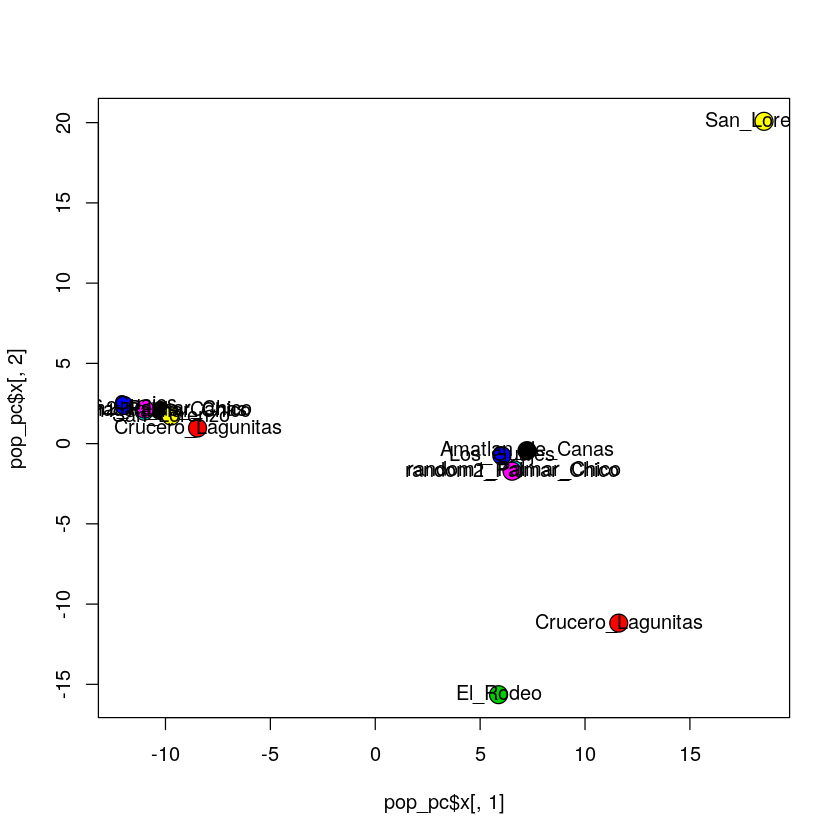

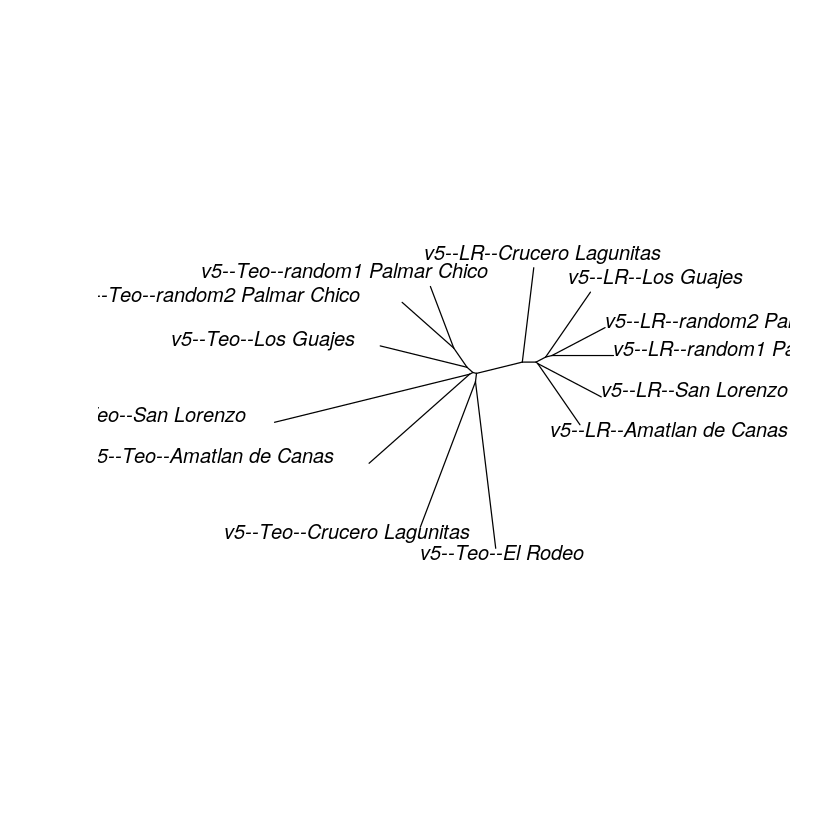

In [3]:
pop_types <- (names(neutral_freqs)[-c(1:3)] %>% str_remove_all('v5--') %>% str_split('--', simplify = TRUE))[,1]
pops <- (names(neutral_freqs)[-c(1:3)] %>% str_remove_all('v5--') %>% str_split('--', simplify = TRUE))[,2]
pop_pc <- neutral_freqs %>% 
    select(-c(chrom, start, end)) %>% 
    t() %>% 
    prcomp()

plot(pop_pc$x[,1], pop_pc$x[,2], bg = factor(pops), pch = 21, cex = 2)
text(pop_pc$x[,1], pop_pc$x[,2], pops)


dist_mat <- neutral_freqs %>% 
    select(-c(chrom, start, end)) %>% 
    t() %>% 
    dist()

plot.phylo(nj(dist_mat), type = "unrooted")

In [4]:
pos_vec <- select(sweep_freqs, end) %>% pull(end)
sweep_mat <- sweep_freqs %>% 
    select(-c(chrom, start, end)) %>% 
    t()

neut_mat <- 
    neutral_freqs %>% 
    select(-c(chrom, start, end)) %>% 
    t()

sel_vec <- c(3,4,5,6,8,9,10,11,12)

param_list <-
  parameter_barge(
    Ne =  10000,
    rec = 1e-7,
    neutral_freqs = neut_mat,
    selected_freqs = sweep_mat,
    selected_pops = sel_vec,
    positions = pos_vec,
    n_sites = 10,
    sample_sizes = rep(10, nrow(neut_mat)),
    num_bins = 100,
    sels = 10^seq(-4, -2, length.out = 20),
    times = c(1e2, 1e4, 1e6),
    gs = 10^seq(-3, -1, length.out = 3),
    migs = 10^(seq(-3, -2, length.out = 2)),      
    sources = sel_vec,
    locus_name = "test_locus",
    cholesky = FALSE
  )


In [5]:
head(param_list$ind_par)



sels,idx
<dbl>,<int>
0.0001000000,1
0.0001274275,2
0.0001623777,3
0.0002069138,4
0.0002636651,5
0.0003359818,6


In [6]:
t <- Sys.time()
#fit composite likelihood models
print("neutral")
suppressWarnings(neut_cle <- mode_cle(param_list, mode = "neutral"))
print("ind")
suppressWarnings(ind_cle <- mode_cle(param_list, mode = "independent"))
print("standing")
suppressWarnings(sv_cle <- mode_cle(param_list, mode = "standing"))
print("mig")
suppressWarnings(mig_cle <- mode_cle(param_list, mode = "migration"))
sv_cle

t - Sys.time()

[1] "neutral"
[1] "ind"
[1] "standing"
[1] "mig"


selected_sites,sels,gs,times,cle,locus,migs,sources,sel_pops,model
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>
999279,0.0001000000,0.001,1e+02,13659.40,test_locus,NA,NA,3-4-5-6-8-9-10-11-12,standing
999279,0.0001000000,0.001,1e+04,13659.40,test_locus,NA,NA,3-4-5-6-8-9-10-11-12,standing
999279,0.0001000000,0.001,1e+06,13659.40,test_locus,NA,NA,3-4-5-6-8-9-10-11-12,standing
999279,0.0001000000,0.010,1e+02,13659.40,test_locus,NA,NA,3-4-5-6-8-9-10-11-12,standing
999279,0.0001000000,0.010,1e+04,13659.40,test_locus,NA,NA,3-4-5-6-8-9-10-11-12,standing
999279,0.0001000000,0.010,1e+06,13659.40,test_locus,NA,NA,3-4-5-6-8-9-10-11-12,standing
999279,0.0001000000,0.100,1e+02,13659.39,test_locus,NA,NA,3-4-5-6-8-9-10-11-12,standing
999279,0.0001000000,0.100,1e+04,13659.38,test_locus,NA,NA,3-4-5-6-8-9-10-11-12,standing
999279,0.0001000000,0.100,1e+06,13659.38,test_locus,NA,NA,3-4-5-6-8-9-10-11-12,standing


Time difference of -6.381814 mins

In [13]:
#merge data frame of all fit models
all_mods <-
  bind_rows(
    ind_cle,
    mig_cle,
    sv_cle
  )

#max composite likelihood estimate 
#of all params over all models  
all_mods %>%
  group_by(model) %>%    
  filter(cle == max(cle,na.rm=T)) %>% 
  arrange(desc(cle))


all_mods %>%
  group_by(model) %>%    
  summarise(mcle = max(cle, na.rm = T) - neut) %>%
  arrange(desc(mcle))



selected_sites,sels,cle,locus,gs,times,migs,sources,sel_pops,model
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1130643,0.0078475997,13723.09,test_locus,NA,NA,0.001,4,3-4-5-6-8-9-10-11-12,migration
1032120,0.0006951928,13673.19,test_locus,0.1,100,NA,NA,3-4-5-6-8-9-10-11-12,standing
1130643,0.0001000000,13659.40,test_locus,NA,NA,NA,NA,3-4-5-6-8-9-10-11-12,independent


model,mcle
<chr>,<dbl>
migration,6.368657e+01
standing,1.379003e+01
independent,-3.517562e-08


`summarise()` has grouped output by 'selected_sites'. You can override using the `.groups` argument.

Warning message in max(cle, na.rm = T):
“no non-missing arguments to max; returning -Inf”
`summarise()` has grouped output by 'sels'. You can override using the `.groups` argument.

Warning message:
“Removed 1 row(s) containing missing values (geom_path).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


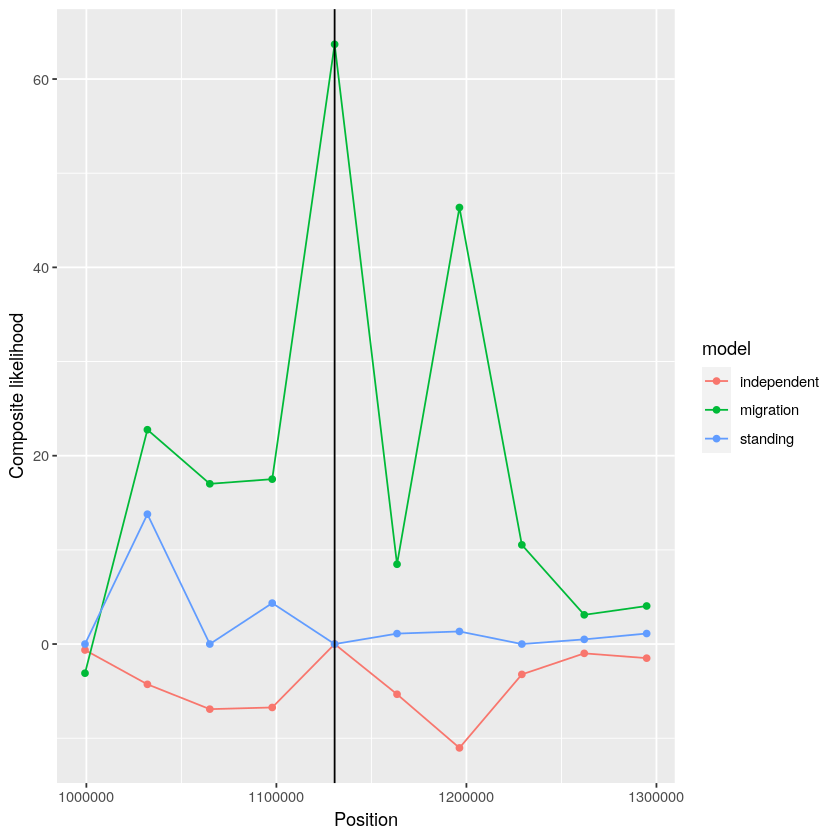

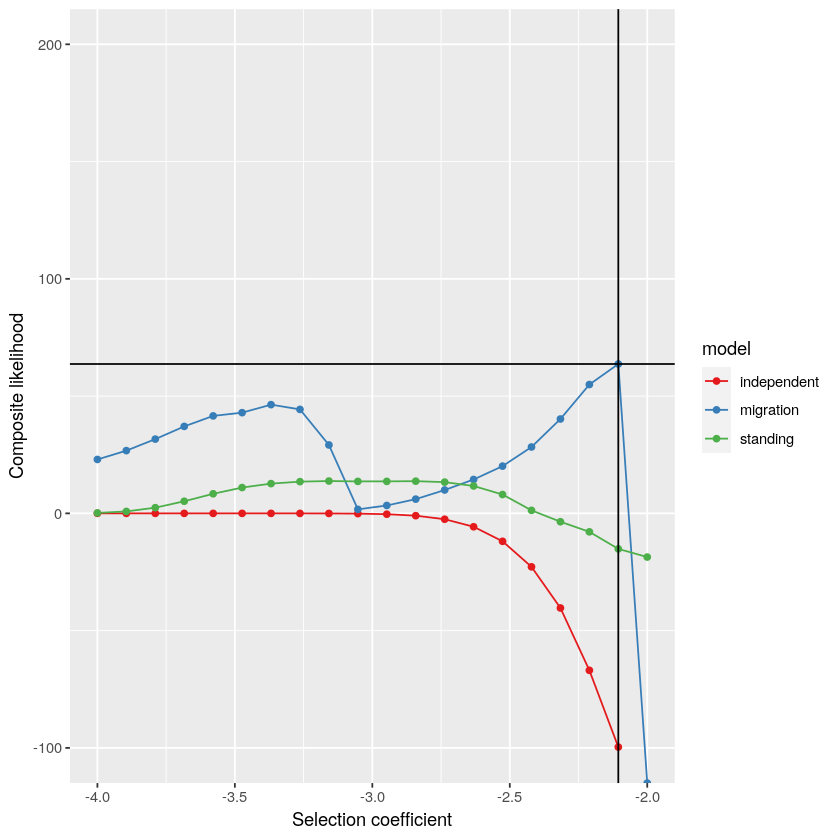

In [21]:
neut <- unique(neut_cle$cle)
all_mods %>%
  group_by(selected_sites, model) %>%
  summarise(mcle = max(cle, na.rm = T) - neut) %>%
  ggplot(aes(selected_sites, mcle, colour = model)) +
  geom_line() +
  geom_point() +
  xlab("Position") +
  ylab("Composite likelihood") +
  geom_vline(xintercept = 1130643)

#visualize likelihood surface wrt selection coefficients
all_mods %>%
  group_by(sels, model) %>%
  summarise(mcle = max(cle, na.rm = T) - neut) %>%
  ggplot(aes(log10(sels), mcle, colour = model)) +
  geom_line() +
  geom_point() +
  ylab("Composite likelihood") +
  xlab("Selection coefficient") +
  scale_color_brewer(palette = "Set1") +
  ylim(-100, 200) +
  geom_hline(yintercept = 6.368657e+01) +
  geom_vline(xintercept = log10(0.0078475997))